In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath('../01.model'))

from model import TransformerModel
from SingleCellDataset import SingleCellDataset
from create_dataloaders import create_dataloaders
from load_data import load_data
from set_seed import set_seed


In [2]:
### GPU
device = torch.device(f'cuda:{5}' if torch.cuda.is_available() else 'cpu')

In [3]:
### load data set
data_path = "../00.preprocessing/101_2981_4118.pth"

expr_tensor, expr_mask, disease_tensor, meta_tensor, celltype_tensor, target_tensor= load_data(data_path, device)
dataset = SingleCellDataset(expr_tensor, expr_mask, disease_tensor, meta_tensor, celltype_tensor, target_tensor)
train_loader, val_loader = create_dataloaders(
    dataset,
    batch_size=24,
    train_ratio=0.8,
    bins=6,
    seed=14
)

/pool1/liujianhong/prj/20250530_scPIT_review/01.model/load_data.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensors = torch.load(data_path)


expr_tensortorch.Size([101, 2891, 4118])
expr_masktorch.Size([101, 2891])
disease_tensortorch.Size([101])
meta_tensortorch.Size([101, 3])
celltype_tensortorch.Size([101, 2891])
target_tensortorch.Size([101])
---------------------------------------------
Data Statistics:
Number of samples: 101
Number of cells per sample: 2891
Number of genes: 4118
Valid cells ratio: 25.57%
FEV1 range: [-2.48, 2.59]
meta_tensor: torch.Size([101, 3])
target_tensor: torch.Size([101])
Bin 0 has less than 2 samples (1 samples), adding to training set.
Bin 6 has less than 2 samples (1 samples), adding to training set.
---------------------------------------------
Train Mean: 0.0061, Std: 1.0111
Val Mean: -0.0220, Std: 0.9589
Number of Train Samples: 79
Number of Validation Samples: 22
---------------------------------------------


In [4]:
### model
model = TransformerModel(
    gene_count=4118,
    dim=128
).to(device)

In [ ]:
### load checkpoint
model_weight = torch.load('../02.checkpoint/model_weights.pth')
model.load_state_dict(model_weight)
model.eval()

/tmp/ipykernel_3210339/1639191599.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weight = torch.load('../02.checkpoint/model_weights.pth')


TransformerModel(
  (cell_mlp): Sequential(
    (0): Linear(in_features=4118, out_features=2048, bias=True)
    (1): ReLU()
    (2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=2048, out_features=512, bias=True)
    (4): ReLU()
    (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (no

In [6]:
### Vaildation set

expr_list = []
mask_list = []
meta_list = []
disease_list = []
celltype_list = []
target_list = []

sample_count = 0
max_samples = 22 

for batch in val_loader:
    expr_list.append(batch['expr'])
    mask_list.append(batch['mask'])
    meta_list.append(batch['meta'])
    disease_list.append(batch['label'])
    celltype_list.append(batch['celltype'])
    target_list.append(batch["target"])

    sample_count += batch['expr'].size(0)
    if sample_count >= max_samples:
        break

# torch.cat
expr_tensor = torch.cat(expr_list, dim=0) # expr_tensor
expr_mask = torch.cat(mask_list, dim=0)  # mask_tensor
meta_tensor = torch.cat(meta_list, dim=0)  # meta_tensor
celltype_tensor = torch.cat(celltype_list, dim=0)  # meta_tensor

disease_tensor = torch.cat(disease_list, dim=0)  # fev1%pred_tensor
disease_tensor = disease_tensor.unsqueeze(1)

target_tensor = torch.cat(target_list, dim=0)  # disease_status_tensor
target_tensor = target_tensor.unsqueeze(1)


# print shape
print(f"expr_tensor_full shape: {expr_tensor.shape}")
print(f"mask_tensor_full shape: {expr_mask.shape}")
print(f"meta_tensor_full shape: {meta_tensor.shape}")
print(f"disease_tensor_tensor_full shape: {disease_tensor.shape}")
print(f"celltype_tensor_full shape: {celltype_tensor.shape}")
print(f"target_tensor_full shape: {target_tensor.shape}")

expr_tensor_full shape: torch.Size([22, 2891, 4118])
mask_tensor_full shape: torch.Size([22, 2891])
meta_tensor_full shape: torch.Size([22, 3])
disease_tensor_tensor_full shape: torch.Size([22, 1])
celltype_tensor_full shape: torch.Size([22, 2891])
target_tensor_full shape: torch.Size([22, 1])


In [7]:
import numpy as np

pred_list=[]
pred_target_list=[]
target_list=[]
patient_embeddings = []
disease_list = []
cell_len_list = []

meta_bmi = []
meta_age = []
meta_sex = []

for sample in range(22):
    sample_expr_tensor = expr_tensor[sample:sample+1]
    sample_meta_tensor = meta_tensor[sample:sample+1]
    sample_expr_mask = expr_mask[sample:sample+1]
    sample_target = disease_tensor[sample:sample+1].cpu().detach().numpy()
    sample_disease = target_tensor[sample:sample+1].cpu().detach().item()

    output = model(sample_expr_tensor, sample_meta_tensor, sample_expr_mask, mode = 'extract')
    patient_embeddings.append(output[2].cpu().detach().numpy()) # patient embeddings

    pred = output[0].cpu().detach().numpy()
    pred_list.append(float(pred))
    target_list.append(float(sample_target))

    pred_target = output[1].cpu()
    probabilities = torch.sigmoid(pred_target)
    predicted_labels = (probabilities > 0.5).float().item()
    pred_target_list.append(int(predicted_labels))

    cell_len = sample_expr_tensor[sample_expr_mask==False].shape[0]
    cell_len_list.append(cell_len)
    meta_bmi.append(float(sample_meta_tensor.tolist()[0][0]))
    meta_age.append(float(sample_meta_tensor.tolist()[0][1]))
    meta_sex.append(float(sample_meta_tensor.tolist()[0][2]))
    if sample_disease == 1:
        disease_list.append("COPD")
    else:
        disease_list.append("Control")
    
    print(f'{sample}\t{float(sample_target):.3f}\t{float(pred):.3f}\t{float(sample_target-pred):.3f}\t{cell_len}\t{int(sample_disease)}\t{int(predicted_labels)}')


/tmp/ipykernel_3210339/2573564229.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_list.append(float(pred))
/tmp/ipykernel_3210339/2573564229.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target_list.append(float(sample_target))
/tmp/ipykernel_3210339/2573564229.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'{sample}\t{float(sample_target):.3f}\t{float(pred):.3f}\t{float(sample_target-pred):.3f}\t{cell_len}\t{int(sample_disease)}\t{int

0	-1.886	-0.827	-1.059	227	1	1
1	-1.900	-1.239	-0.661	1121	1	1
2	-1.092	-0.557	-0.534	191	1	1
3	-1.378	-0.471	-0.907	2054	1	1
4	-1.208	-0.575	-0.633	149	1	1
5	-0.116	0.244	-0.361	1523	1	0
6	0.017	0.067	-0.050	432	1	1
7	-0.658	-0.381	-0.277	1170	1	1
8	-0.424	-0.075	-0.349	853	1	1
9	0.171	0.190	-0.019	1279	1	0
10	0.245	-0.178	0.423	894	1	0
11	0.871	1.387	-0.516	294	0	0
12	0.828	0.318	0.509	2000	0	0
13	0.646	0.102	0.544	247	0	1
14	0.152	0.232	-0.080	1039	1	0
15	0.441	0.253	0.187	341	0	0
16	0.146	-0.280	0.426	74	1	1
17	0.209	0.076	0.133	261	0	1
18	0.561	-0.126	0.687	570	0	1
19	1.022	0.719	0.303	215	0	0
20	1.734	0.679	1.055	2744	0	0
21	1.139	0.358	0.781	1332	0	1


In [8]:
all_true = []
for i in range(22):
    if disease_list[i]=="COPD":
        disease = 1
    else:
        disease = 0
    if disease == pred_target_list[i]:
        all_true.append(1)
    else:
        all_true.append(0)
all_true = np.array(all_true)
cell_len_list = np.array(cell_len_list)

all_select_true = np.array([0,1,1,1,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0])
all_select_true = np.array([1,2,2,2,2,0,1,2,1,0,0,2,2,0,0,2,1,0,0,2,2,0])

print(all_true)
    

[1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0]


/tmp/ipykernel_3210339/1805403596.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x, pred_summary['mean'], 'r-', label='Fitted Line', color = "#1E90FF")


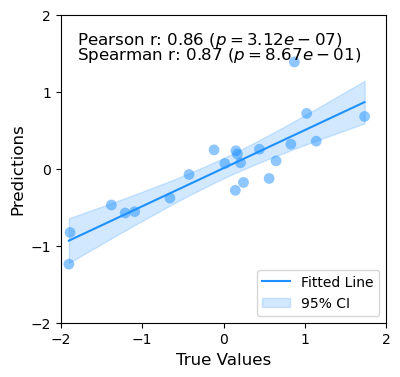

In [9]:
### predicted FEV1%pred vs observed FEV1%pred

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

pearson_corr, pearson_pval = pearsonr(pred_list, target_list)
spearman_corr, spearman_pval = spearmanr(pred_list, target_list)

x = np.array(target_list)
y = np.array(pred_list)
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# intercept
x_with_const = sm.add_constant(x)
model_sm = sm.OLS(y, x_with_const).fit()

# 95% onfidence interval
pred = model_sm.get_prediction(x_with_const)
pred_summary = pred.summary_frame(alpha=0.05)

# scatter plot
plt.figure(figsize=(4.2, 4))
plt.scatter(target_list, pred_list, alpha=0.5, color = "#1E90FF", edgecolors='none', s=60)
plt.plot([min(target_list), max(target_list)], 
        [min(target_list), max(target_list)], 
        'r--', alpha = 0)
plt.plot(x, pred_summary['mean'], 'r-', label='Fitted Line', color = "#1E90FF")
plt.fill_between(x, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], 
                 color='#1E90FF', alpha=0.2, label='95% CI')

plt.xticks([-2, -1, 0, 1, 2])
plt.yticks([-2, -1, 0, 1, 2])  
plt.xlim(-2, 2)
plt.ylim(-2, 2)

# text
plt.text(0.05, 0.95, f'Pearson r: {pearson_corr:.2f} ($p={pearson_pval:.2e}$)',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, f'Spearman r: {spearman_corr:.2f} ($p={spearman_corr:.2e}$)',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title("")
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.legend()
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.grid(False)
# plt.savefig("./val_scatter_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/liujianhong/anaconda3/envs/liujh_pytorch/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


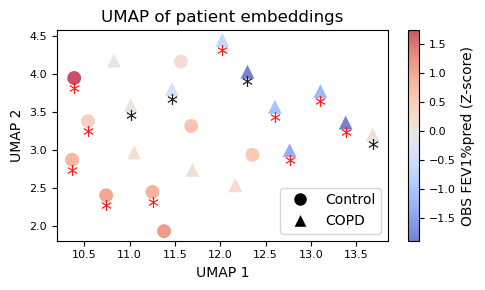

In [10]:
### Vis patient embedding

import numpy as np
import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
patient_embeddings = np.vstack(patient_embeddings)

# UMAP
reducer = umap.UMAP(n_neighbors=42, min_dist=0.01, n_components=2, random_state=2)
embedding_umap = reducer.fit_transform(patient_embeddings)
# shape of group
group_markers = {"Control": 'o', "COPD": '^'}
group_array = np.array(disease_list)
pred_list = np.array(pred_list)
target_list = np.array(target_list)
meta_bmi = np.array(meta_bmi)
meta_age = np.array(meta_age)
meta_sex = np.array(meta_sex)
# plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
point_sizes = 100

for i, group in enumerate(group_markers.keys()):
    group_indices = group_array == group
    x_coords = embedding_umap[group_indices, 0]
    y_coords = embedding_umap[group_indices, 1]
    labels = all_select_true[group_indices]  # label content
    
    # UMAP plot
    scatter_umap = ax.scatter(
        x_coords,
        y_coords,
        c=target_list[group_indices],
        cmap='coolwarm',
        s=point_sizes,
        marker=group_markers[group],
        alpha=0.7,
        label=f'Group {group}',
        vmin=np.min(target_list),
        vmax=np.max(target_list),
        edgecolors='none'
    )
    
    # marking for each point
    for x, y, label in zip(x_coords, y_coords, labels):
        if label == 1:
            ax.text(
                x, y-0.2, str("*"),
                fontsize=16,
                color='black',
                ha='center',
                va='center',
                alpha=0.9
            )
        elif label == 2:
            ax.text(
                x, y-0.2, str("*"),
                fontsize=16,
                color='red',
                ha='center',
                va='center',
                alpha=0.9
            )

ax.set_title("UMAP of patient embeddings")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
cbar_umap = plt.colorbar(scatter_umap, ax=ax, label="OBS FEV1%pred (Z-score)")
cbar_umap.ax.tick_params(labelsize=8)
# axis x y
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
# legend
handles = [plt.Line2D([0], [0], marker=marker, color='w', markerfacecolor='k', markersize=10) for marker in group_markers.values()]
ax.legend(handles, [f'{group}' for group in group_markers.keys()], title="", loc='lower right')
# plt.xticks([17,18,19,20,21])
# plt.yticks([-9.5, -8.5, -7.5,-6.5]) 
plt.tight_layout()
# plt.savefig("./embedding_umap.pdf", format="pdf", bbox_inches="tight")
plt.show()